In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

##### Explore data

In [2]:
def load_data():
    # Load a list of all the image files
    images_list = glob.glob(r'../images/**/*.png', recursive=True)
    # Create placeholders for car and noncar file names
    cars = []
    noncars = []
    # Iterate through all images and seggregate them into car and noncar lists
    for image in images_list:
        if 'non-vehicles' in image:
            noncars.append(image)
        else:
            cars.append(image)
    # Return the car and noncar lists
    return cars, noncars

In [3]:
def explore_data(cars, noncars):
    # Create a dictionary to hold the meta data
    data_dict = {}
    # Define keys for holding number of car and noncar images
    data_dict['n_cars'] = len(cars)
    data_dict['n_notcars'] = len(noncars)
    test_img = mpimg.imread(cars[0])
    data_dict['img_shape'] = test_img.shape
    data_dict['data_type'] = test_img.dtype
    # Return the data_dict
    return data_dict

In [4]:
cars, notcars = load_data()

In [5]:
data_dict = explore_data(cars, notcars)
print(data_dict)
print('img format:', cars[0][-4:])
test_img = mpimg.imread(cars[0])
print('min/max of one pic:', np.min(test_img), '/', np.max(test_img))

{'img_shape': (64, 64, 3), 'data_type': dtype('float32'), 'n_cars': 8792, 'n_notcars': 8968}
img format: .png
min/max of one pic: 0.129412 / 0.752941


##### features exraction

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # using skimage hog, get both visualization and features vector
        features, hog_image = hog(img, orientations=orient, pixels_per_cell = (pix_per_cell, pix_per_cell), 
                                            cells_per_block=(cell_per_block, cell_per_block),
                                            transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        # get only features vector
        features = hog(img, orientations=orient, pixels_per_cell = (pix_per_cell, pix_per_cell), 
                                            cells_per_block=(cell_per_block, cell_per_block),
                                            transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features

In [7]:
def bin_spatial(img, size=(32,32)):
    # Resize the image to specified size and ravel
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [8]:
def color_hist(img, nbins=32): #, bins_range=(0, 256)):
    # Extract and compute histograms of each channel separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins) #, range=bins_range)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins) #, range=bins_range)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins) #, range=bins_range)
    # Concatenate the histogram features into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    
    return hist_features

In [9]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a features list to append features list to
    features = []
    # Itereate through all the images
    for file in imgs:
        file_features = []
        # Open image
        img = mpimg.imread(file)
        # Verify and convert if a color space  other than 'RGB' is mentioned
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            feature_img = np.copy(img)

        if spatial_feat == True:
            # Get spatial features
            spatial_features = bin_spatial(feature_img, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            # Get color histogram features
            hist_features = color_hist(feature_img, nbins=hist_bins)
            file_features.append(hist_features)
    
        if hog_feat == True:
            # Call hog features with vis=False as not required
            if hog_channel=='ALL':
                hog_features = []
                for channel in range(feature_img.shape[2]):
                    hog_features.append(get_hog_features(feature_img[:,:,channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.concatenate(hog_features)
            else:
                hog_features = get_hog_features(feature_img[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return the combined features set
    return features

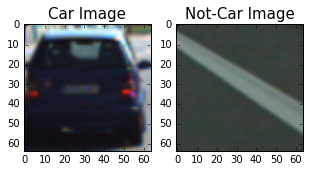

In [10]:
%matplotlib inline

# choose a car/notcar indices at random
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read car and notcar images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])
f, (ax1, ax2) = plt.subplots(1,2, figsize=(5,3))
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=15)
ax2.imshow(notcar_image)
ax2.set_title('Not-Car Image', fontsize=15)

### Train Classifier

In [11]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, 680] # Min and max in y to search in slide_window()

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0,len(cars), n_samples)
test_cars = cars # np.array(cars)[random_idxs]
test_notcars = notcars # np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time() - t, 'seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), (np.zeros(len(notcar_features)))))

# Split up train and test sets
rand_state = np.random.randint(100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

train_new_classifier = False
if train_new_classifier:
    # Using LinearSVC
    svc = LinearSVC(C=0.1)
    # Timing the LinearSVC classifier
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    joblib.dump(svc, 'svc_classifier.pkl')
    joblib.dump(X_scaler, 'scaler.pkl')
else:
    svc = joblib.load('svc_classifier.pkl')
    X_scaler = joblib.load('scaler.pkl')

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

72.00119972229004 seconds to compute features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
0.001 Seconds to predict 10 labels with SVC
Test Accuracy of SVC =  0.9989


In [12]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop are not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Calculate the span of the image region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y directions
    nx_pixels_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pixels_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    nx_windows = np.int(xspan/nx_pixels_per_step) - 1
    ny_windows = np.int(yspan/ny_pixels_per_step) - 1
    
    # Initialize a list to hold the window positions
    window_list = []
    # Loop through to find x/y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pixels_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pixels_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return window list
    return window_list

In [13]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    # Create a features list to append features list to
    img_features = []
    # Apply color space conversions if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_img = np.copy(img)
    
    if spatial_feat == True:
        # Get spatial features
        spatial_features = bin_spatial(feature_img, size=spatial_size)
        img_features.append(spatial_features)
    
    if hist_feat == True:
        # Get color histogram features
        hist_features = color_hist(feature_img, nbins=hist_bins)
        img_features.append(hist_features)
    
    if hog_feat == True:
        # Call hog features with vis=False as not required
        if hog_channel=='ALL':
            hog_features = []
            hog_image = []
            for channel in range(feature_img.shape[2]):
                hog_features.append(get_hog_features(feature_img[:,:,channel], orient,
                                                     pix_per_cell, cell_per_block, 
                                                     vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_img[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, 
                                            vis=True, feature_vec=True)
                hog_image = hog_image
            else:
                 hog_features = get_hog_features(feature_img[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
        img_features.append(hog_features)
        
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [14]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [15]:
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through all the box coordinates
    for bbox in bboxes:
        # Draw box on the image copy
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return image with all boxes drawn
    return imcopy

In [16]:
def visualize(fig, rows, cols, images, titles):
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

0.4334075450897217 seconds to process one image searching 100 windows
0.4458043575286865 seconds to process one image searching 100 windows
0.47383666038513184 seconds to process one image searching 100 windows
0.45684051513671875 seconds to process one image searching 100 windows
0.4408111572265625 seconds to process one image searching 100 windows
0.4102926254272461 seconds to process one image searching 100 windows


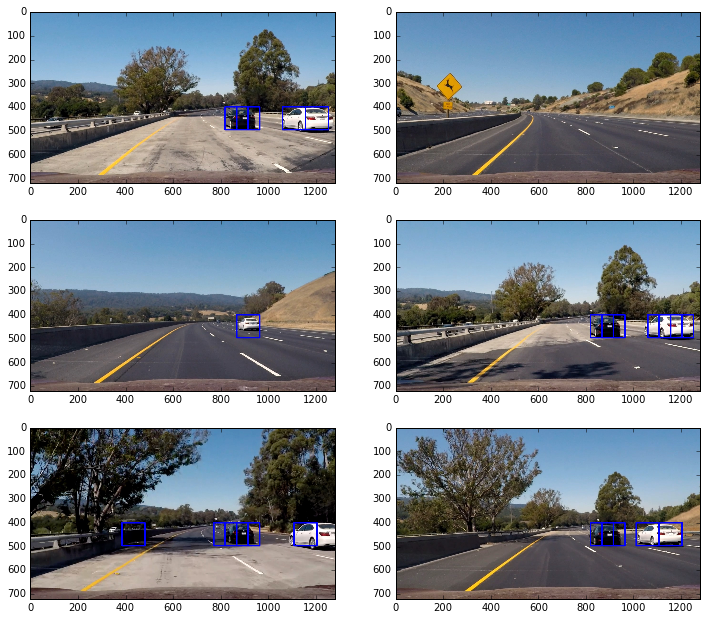

In [17]:
#searchpath = 'E:\Udacity\SDCND\Projects\P5\CarND-Vehicle-Detection-master\test_images'
searchpath = './test_images/*'
example_images = glob.glob(searchpath)

images = []
titles = []
y_start_stop = [400, 656]
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #print('min/max of img:', np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(96,96), xy_overlap=(overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_image = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_image)
    titles.append('')
    print(time.time() - t1, 'seconds to process one image searching', len(windows), 'windows')

fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)

### HOG subsampling

In [18]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [19]:
#def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
def find_cars(img, scale=1, ystart=400, ystop=656):
    
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -  1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                #img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap

In [20]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return the thresholded heatmap
    return heatmap

In [21]:
def draw_labelled_bboxes(img, labels):
    # Iterate through all the detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        #bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Define a bounding box based on min/max x and y
        max_x = np.max(nonzerox) 
        min_x = np.min(nonzerox)
        max_y = np.max(nonzeroy)
        min_y = np.min(nonzeroy)
        if( (max_x - min_x >50) and (max_y - min_y > 50) ):
            bbox = ((min_x, min_y), (max_x, max_y))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 4)
    # Return the image
    return img

In [22]:
#def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
def my_find_cars(img, scale, ystart=400, ystop=656):
    
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    #global global_hot_windows
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -  1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    print('scale/nxsteps/nysteps', scale, nxsteps, nysteps)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            #if test_prediction == 1:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
            #img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
            #global_hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            
    return draw_img, heatmap

scale/nxsteps/nysteps 1 76 5
scale/nxsteps/nysteps 1.3 57 4
scale/nxsteps/nysteps 1.5 49 4
scale/nxsteps/nysteps 1.7 43 3
scale/nxsteps/nysteps 2 36 4


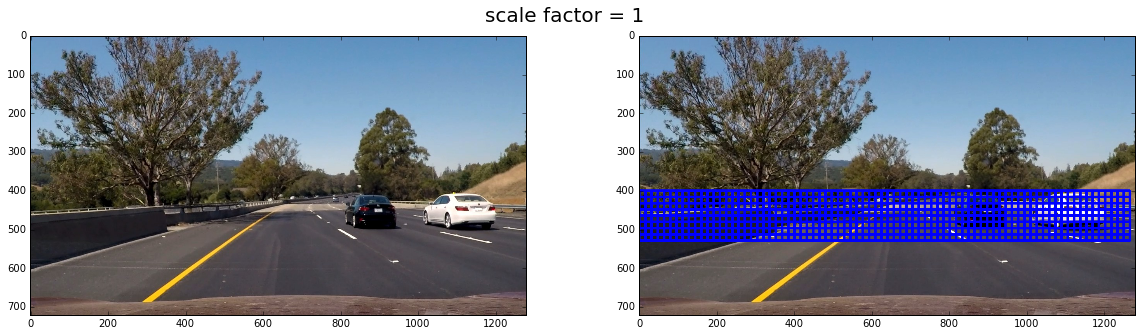

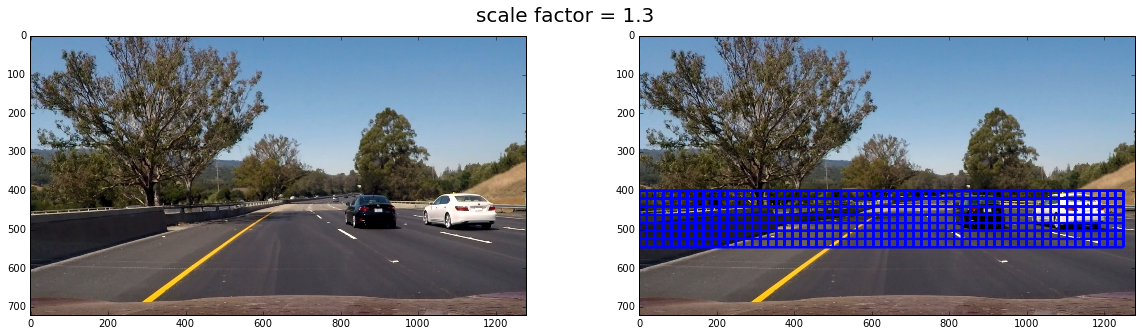

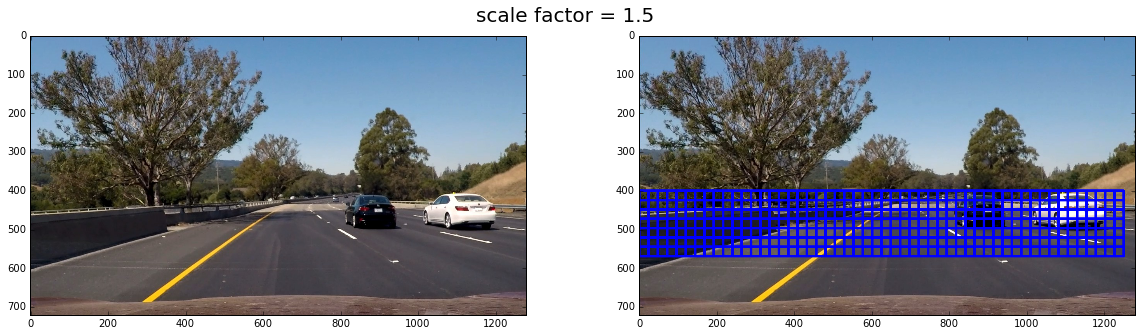

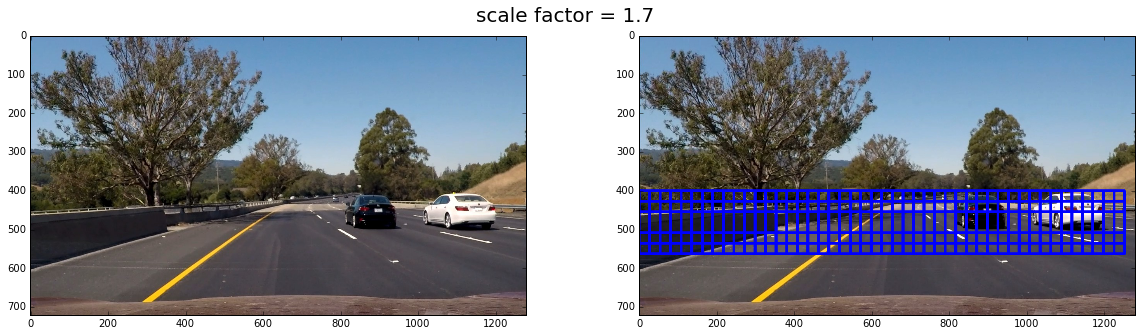

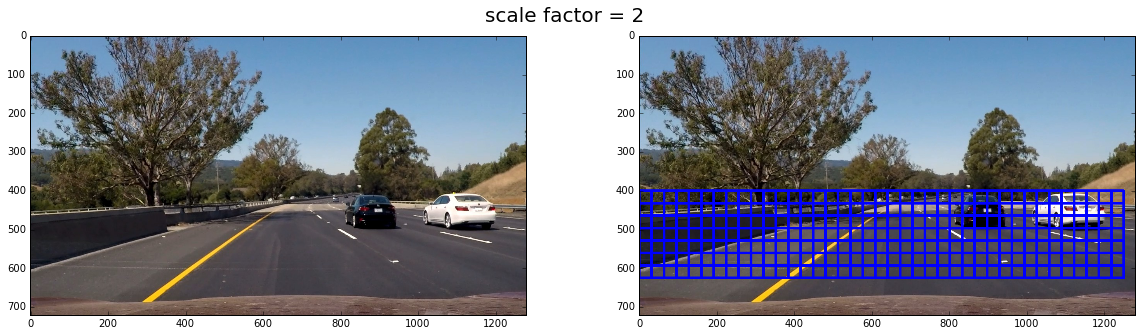

In [23]:
file = example_images[5]
image = mpimg.imread(file)

frame_heat = np.zeros_like(image[:,:,0])
scales = [1, 1.3, 1.5, 1.7, 2]
ystart = [400, 400, 400, 400, 400]
ystop = [552, 571, 596, 615, 656]
for scale, start, stop in zip(scales, ystart, ystop):
    draw, heat = my_find_cars(image , scale, start, stop)
    frame_heat += heat
    f,(ax1,ax2) = plt.subplots(1,2,figsize =(20,5))
    ax1.imshow(image)
    ax2.imshow(draw)
    plt.suptitle('scale factor = ' + str(scale), fontsize=20)
plt.show()

./test_images\test1.jpg  has labels: 2


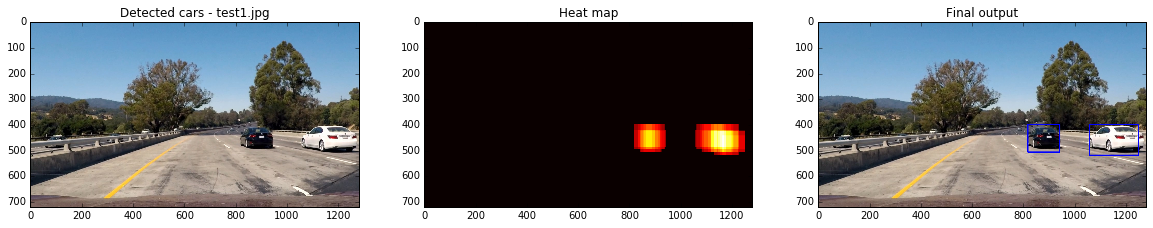

./test_images\test2.jpg  has labels: 0


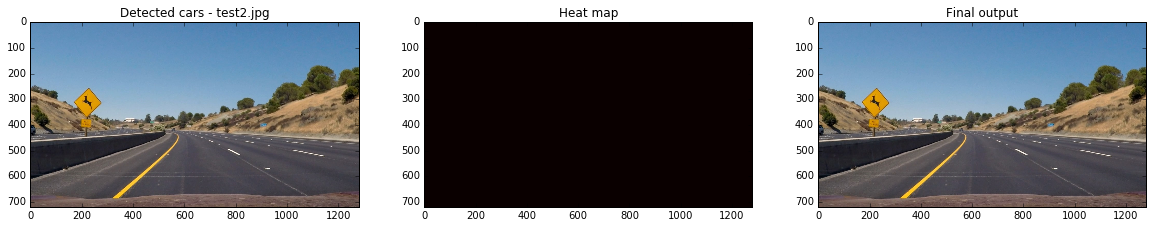

./test_images\test3.jpg  has labels: 0


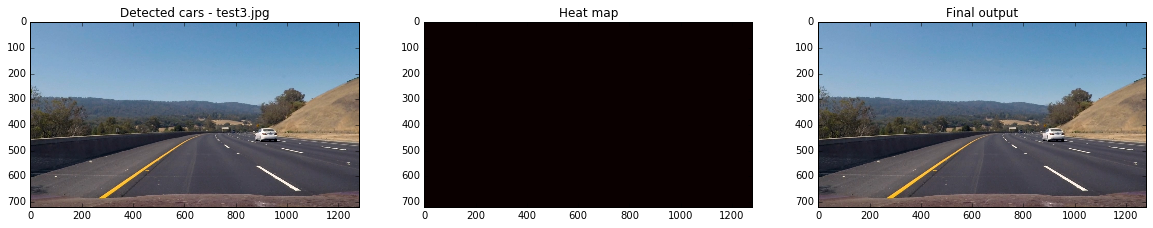

./test_images\test4.jpg  has labels: 2


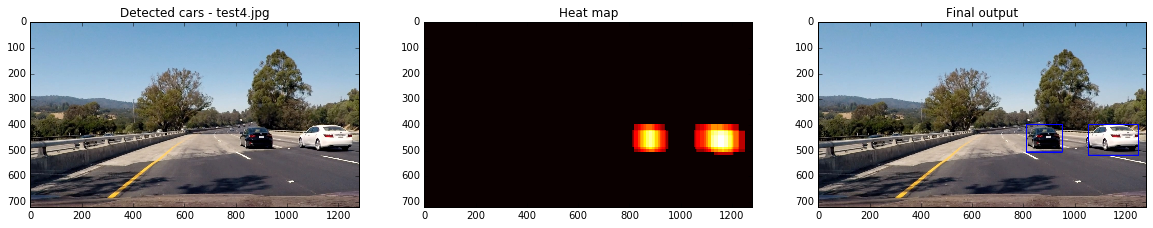

./test_images\test5.jpg  has labels: 2


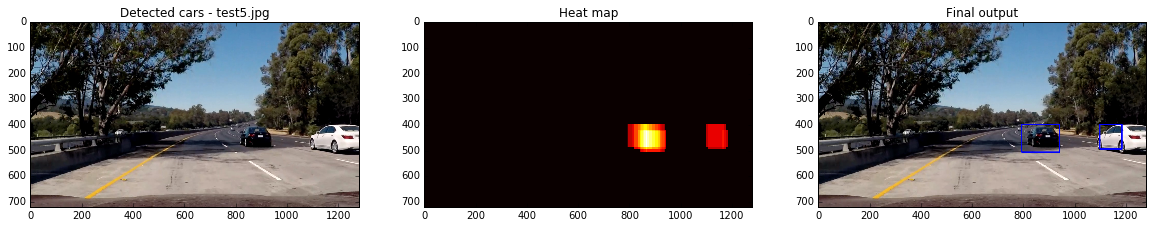

./test_images\test6.jpg  has labels: 2


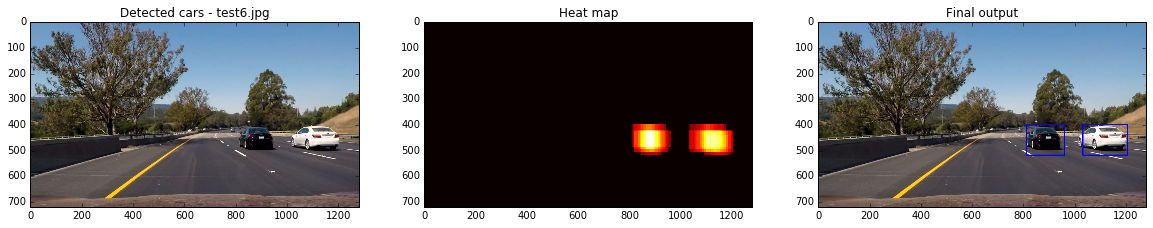

In [24]:
for file in example_images:
    image = mpimg.imread(file)
    final_out = np.copy(image)
    detected_windows = []
    corrected_windows = np.zeros_like(image[:,:,0])

    draw , heatmap = find_cars(image , scale = 1.7)
    #detected_windows.append(draw)
    corrected_windows = heatmap
    draw , heatmap = find_cars(image , scale = 1.37)
    #detected_windows.append(draw)
    corrected_windows += heatmap
    draw , heatmap = find_cars(image , scale = 1.5)
    #detected_windows.append(draw)
    corrected_windows += heatmap
    #detected_windows = np.concatenate(detected_windows)
    detected_windows = draw
    heatmap = apply_threshold(corrected_windows , threshold = 3)
    labels = label(heatmap)
    print(file, ' has labels:',labels[1])
    final_out = draw_labelled_bboxes(final_out,labels)

    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize =(20,10))
    #ax1.imshow(cv2.cvtColor(detected_windows,cv2.COLOR_BGR2RGB))
    ax1.imshow(detected_windows)
    ax2.imshow(corrected_windows,cmap = 'hot')
    #ax3.imshow(cv2.cvtColor(final_out,cv2.COLOR_BGR2RGB))
    ax3.imshow(final_out)
    ax1.set_title('Detected cars - ' + str(file[-9:]))
    ax2.set_title('Heat map')
    ax3.set_title('Final output')
    # ax2.imshow(heatmap , cmap = 'hot')
    plt.show()

In [25]:
num_frames_used = 20
cumulative_heat = np.zeros((num_frames_used, 720, 1280))
frameNum = 0
alpha = 0.6
def process_image(image):
    global cumulative_heat
    global frameNum
    
    frame_heat = np.zeros_like(image[:,:,0])
    scales = [1, 1.3, 1.5, 1.7, 2]
    ystart = [400, 400, 400, 400, 400]
    ystop = [552, 571, 596, 615, 656]
    for scale, start, stop in zip(scales, ystart, ystop):
        _, heat = find_cars(image , scale, start, stop)
        frame_heat += heat
    
    heatmap  = (alpha * np.mean(cumulative_heat,axis = 0)) + ((1 - alpha) * frame_heat)
    heatmap = apply_threshold(heatmap, 3)
    labels = label(heatmap)
    cumulative_heat[frameNum] = frame_heat
    frameNum = (frameNum + 1) % num_frames_used
    
    final = draw_labelled_bboxes(image, labels)
    return final

In [26]:
# Import video support files
from moviepy.editor import VideoFileClip

input_video = '../CarND-Vehicle-Detection-master/project_video.mp4'
test_output = 'project_output.mp4'

clip = VideoFileClip(input_video)
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████████████████████████▉| 1260/1261 [31:06<00:01,  1.45s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 



In [27]:
from IPython.display import HTML
test_output = 'project_output.mp4'

HTML("""
<video width='960', height='540' controls>
    <source src="{0}">
</video>
""".format(test_output))